In [1]:
# Parameters
artificial_humans = "../../data/artificial_humans/01_rnn_edge_features/model/rnn_True__edge_True__global_features_False.pt"
artificial_humans_model = "graph"
manager = "../../data/manager_v3/17_model/model/rnn_True__edge_False__global_features_False__run_0.pt"
output_path = "../../data/manager/simulate_rule/v1_comp/"
n_episode_steps = 16
n_episodes = 10000


In [2]:
%load_ext autoreload
%autoreload 2

import os
import torch as th
import numpy as np
import seaborn as sns
import pandas as pd
from itertools import count
from aimanager.utils.utils import make_dir

from aimanager.manager.memory import Memory
from aimanager.manager.environment_v3 import ArtificialHumanEnv
from aimanager.manager.manager import ArtificalManager
from aimanager.artificial_humans import GraphNetwork
from aimanager.utils.array_to_df import using_multiindex, add_labels

output_path = os.path.join(output_path, 'data')

/home/mpib/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mpib/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
device = th.device('cpu')
rec_device = th.device('cpu')
artifical_humans = GraphNetwork.load(artificial_humans, device=th.device('cpu'))

mg = ArtificalManager.load(manager, device=th.device('cpu'))


n_agents_set = list(range(3, 9))

dfs = []
for e, n_agents in enumerate(n_agents_set):

    env = ArtificialHumanEnv(
        artifical_humans=artifical_humans, n_agents=4, n_contributions=21, n_punishments=31, 
        n_rounds=n_episode_steps, batch_size=n_episodes, device=device)

    recorder = Memory(n_episodes=1, n_episode_steps=n_episode_steps, output_file=None, device=device)

    state = env.reset()
    for round_number in count():
        print(round_number)
        _state = {**state, **env.get_batch_structure()}
        encoded = mg.encode_pure(_state)

        q_values = mg.get_q(encoded, first=round_number == 0)

        action = q_values.argmax(-1)

        state = env.punish(action)

        recorder.add(**{k: v.squeeze(-1) for k, v in state.items()}, episode_step=round_number)
        state, reward, done = env.step()
        if done:
            break
# recorder.next_episode(episode)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [5]:
columns = ['round_number','participant_code']
# columns = ['round_number']

punishments = using_multiindex(recorder.memory['punishments'][0].numpy(), columns=columns, value_name='punishment')
common_good = using_multiindex(recorder.memory['common_good'][0].numpy(), columns=columns, value_name='common_good')
contributions = using_multiindex(recorder.memory['contributions'][0].numpy(), columns=columns, value_name='contribution')

df_sim = punishments.merge(common_good).merge(contributions)
df_sim['data_source'] = 'simulation'

data_file = "../../data/experiments/pilot_random1_player_round_slim.csv"
experiment_names = ['trail_rounds_2']

df_pilot = pd.read_csv(data_file)

df_pilot = df_pilot[df_pilot['experiment_name'].isin(experiment_names)]
df_pilot = df_pilot[['round_number', 'common_good', 'contribution', 'participant_code', 'punishment']]


df_pilot['data_source'] = 'pilot'


df = pd.concat([df_sim, df_pilot]).reset_index(drop=True)

dfm = df.melt(
    id_vars=['round_number', 'participant_code', 'data_source'], 
    value_vars=['punishment', 'contribution'])


# df = df.drop(columns=['idx'])

# df = df.groupby(['round_number', 'agent', 's']).mean().reset_index()
# df = add_labels(df, labels=labels)

# make_dir(output_path)
# df.to_csv(os.path.join(output_path, 'trace.csv'))

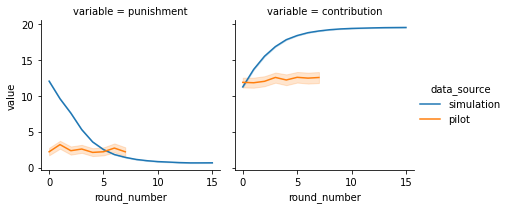

In [6]:
g = sns.relplot(
    data=dfm,
    x="round_number", 
    y="value",
    col='variable',
    hue='data_source',
    kind="line",
    height=3, aspect=1,
)


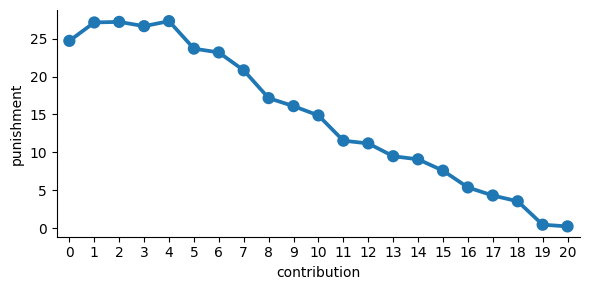

In [7]:
g = sns.catplot(
    data=df_sim,
    x="contribution", 
    y="punishment",
    kind="point",
    height=3, aspect=2,
)

In [15]:
df_sim.groupby(['round_number', 'contribution'])['punishment'].mean()[0]

contribution
0     29.0
1     29.0
2     29.0
3     29.0
4     29.0
5     21.0
6     21.0
7     16.0
8     10.0
9     10.0
10    10.0
11    10.0
12    10.0
13    10.0
14    10.0
15     5.0
16     3.0
17     3.0
18     3.0
19     3.0
20     3.0
Name: punishment, dtype: float64

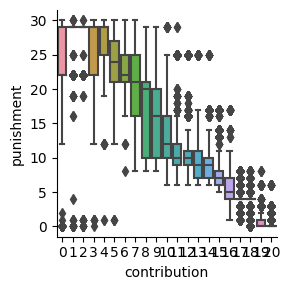

In [8]:
g = sns.catplot(
    data=df_sim,
    x="contribution", 
    y="punishment",
    kind="box",
    height=3, aspect=1,
)

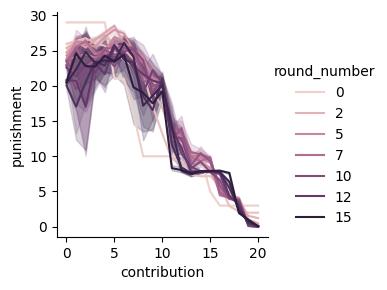

In [9]:
g = sns.relplot(
    data=df_sim,
    x="contribution", 
    y="punishment",
    hue='round_number',
    kind="line",
    height=3, aspect=1,
)